# CAB420, Sequenes, Example 2: Sequence to Sequence Prediction
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
Often when dealing with sequences, often we wish to predict a sequence as our output. We can easily use neural networks to do that as well.

## Too Long; Didn't Read:
* Sometimes, the output for a sequence is another sequence. Language translation is a classic example of this where a sentence in one language is mapped to a sentence in another.
* To make such predictions, we simply ask our recurrent network to generate a sequential output.
* We may also wish to use a bi-directional recurrent network, which will parse the input forwards and backwards, allowing the network to better understand the data and dependancies within it.

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Bidirectional, TimeDistributed
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scipy.io
from tensorflow.keras.utils import model_to_dot, plot_model

## The Data
Our data comes from the Edinburgh Informatics Forum pedestrian dataset: http://homepages.inf.ed.ac.uk/rbf/FORUMTRACKING/.
This contains trajectories for a bunch of people as they move through a buliding foyer. Our task will be to predict the next part of the trajectory. Out input will be:
* The first 50 observations of a trajectory

From which we'll try to predict
* The next 50 observations of a trajectory

Essentially, this is a sequence to sequence regression task.
We have a bunch of files for different days that we'll load up and break down.

In [2]:
def parsedata(data, in_length, out_length, window_step, subsample):

    in_traj = []
    out_traj = []

    for i in range(len(data)):
        
        traj = data[i][:, 0:2].astype('float32')
        traj[:, 0] = traj[:, 0] / 640
        traj[:, 1] = traj[:, 1] / 480
               
        startpos = 1
        endpos = in_length + out_length;
        
        while (endpos < len(traj)):
            
            traj_in = traj[startpos:startpos+in_length:subsample, :]
            traj_out = traj[startpos+in_length:endpos:subsample, :]
                        
            vel_in = numpy.sum(numpy.abs(traj_in[0, :] - traj_in[-1, :])) / len(traj_in)
            vel_out = numpy.sum(numpy.abs(traj_out[0, :] - traj_out[-1, :])) / len(traj_out)
                        
            if ((vel_in > 0.005) & (vel_out > 0.005)):
                in_traj.append(traj_in)
                out_traj.append(traj_out)
            
            startpos += window_step
            endpos += window_step
    
    return in_traj, out_traj

In [3]:
data = scipy.io.loadmat('../data/EIF/aug24.mat')
aug24_in, aug24_out = parsedata(data['aug24'][0], 50, 50, 10, 2)
data = scipy.io.loadmat('../data/EIF/aug25.mat')
aug25_in, aug25_out = parsedata(data['aug25'][0], 50, 50, 10, 2)
data = scipy.io.loadmat('../data/EIF/aug26.mat')
aug26_in, aug26_out = parsedata(data['aug26'][0], 50, 50, 10, 2)
data = scipy.io.loadmat('../data/EIF/aug27.mat')
aug27_in, aug27_out = parsedata(data['aug27'][0], 50, 50, 10, 2)
data = scipy.io.loadmat('../data/EIF/aug28.mat')
aug28_in, aug28_out = parsedata(data['aug28'][0], 50, 50, 10, 2)
data = scipy.io.loadmat('../data/EIF/aug29.mat')
aug29_in, aug29_out = parsedata(data['aug29'][0], 50, 50, 10, 2)
data = scipy.io.loadmat('../data/EIF/sep01.mat')
sep01_in, sep01_out = parsedata(data['sep01'][0], 50, 50, 10, 2)
data = scipy.io.loadmat('../data/EIF/sep02.mat')
sep02_in, sep02_out = parsedata(data['sep02'][0], 50, 50, 10, 2)
data = scipy.io.loadmat('../data/EIF/sep04.mat')
sep04_in, sep04_out = parsedata(data['sep04'][0], 50, 50, 10, 2)
data = scipy.io.loadmat('../data/EIF/sep05.mat')
sep05_in, sep05_out = parsedata(data['sep05'][0], 50, 50, 10, 2)
data = scipy.io.loadmat('../data/EIF/sep06.mat')
sep06_in, sep06_out = parsedata(data['sep06'][0], 50, 50, 10, 2)

We'll use the first 9 files for training, and the last 2 for testing.

In [4]:
train_X = aug24_in + aug25_in + aug26_in + aug27_in + aug28_in + aug29_in + sep01_in + sep02_in + sep04_in
train_Y = aug24_out + aug25_out + aug26_out + aug27_out + aug28_out + aug29_out + sep01_out + sep02_out + sep04_out
test_X = sep05_in + sep06_in
test_Y = sep05_out + sep06_out

print(len(train_X))
print(len(train_Y))
print(len(test_X))
print(len(test_Y))

8126
8126
325
325


In [5]:
train_X = numpy.array(train_X)
train_Y = numpy.array(train_Y)
test_X = numpy.array(test_X)
test_Y = numpy.array(test_Y)

print(numpy.shape(train_X))
print(numpy.shape(train_Y))
print(numpy.shape(test_X))
print(numpy.shape(test_Y))

(8126, 25, 2)
(8126, 25, 2)
(325, 25, 2)
(325, 25, 2)


We can visualise some of the days too to have a look at what we're dealing with.

Text(0.5, 1.0, 'September 5')

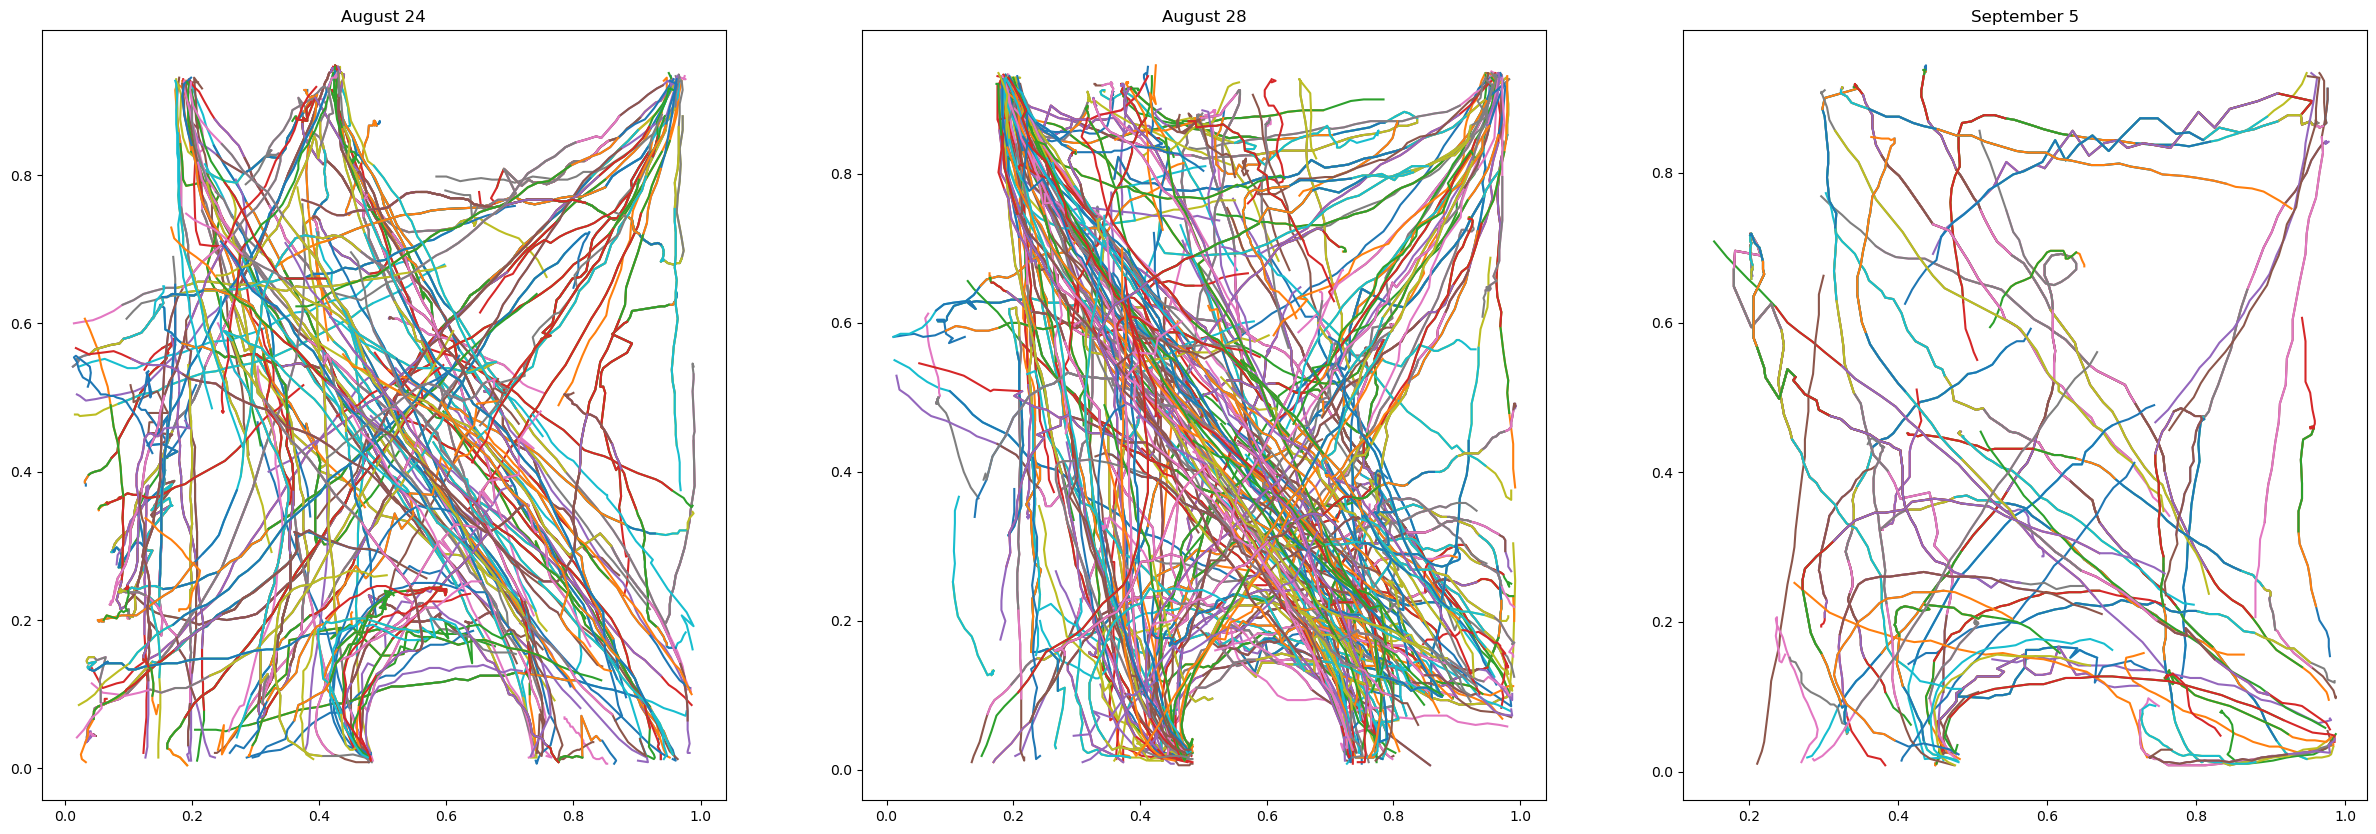

In [6]:
fig = plt.figure(figsize=[30, 10])
ax = fig.add_subplot(1, 3, 1)
for i in aug24_in:
    ax.plot(i[:,0], i[:,1])
ax.set_title('August 24')
    
ax = fig.add_subplot(1, 3, 2)
for i in aug28_in:
    ax.plot(i[:,0], i[:,1])
ax.set_title('August 28')

ax = fig.add_subplot(1, 3, 3)
for i in sep05_in:
    ax.plot(i[:,0], i[:,1])    
ax.set_title('September 5')    

## Approach 1: Sequence to Sequence Model
Let's start with a simple model. This can be seen as an encoder-decoder where:
* Our encoder is an LSTM that produces a sequence output
* Our decoder is an LSTM that produces a sequence output

We'll then have a sigmoid activation for the [0..1] range that we have in our output, and use a MSE loss

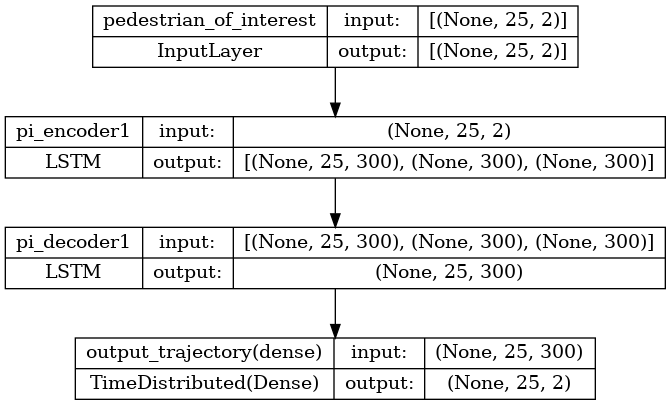

In [7]:
hidden_dim = 300
pi_input = Input(shape = (25, 2), name = 'pedestrian_of_interest')
encoder_outputs, e1_h, e1_c = LSTM(hidden_dim, return_sequences=True, return_state=True, 
                                   unroll=False, name='pi_encoder1')(pi_input)
e1_states = [e1_h, e1_c]
decoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=False, 
                                unroll=False, name='pi_decoder1')(encoder_outputs, initial_state=e1_states)
output = TimeDistributed(Dense(2), name='output_trajectory')(decoder_lstm)

model = Model(pi_input, output)

model.compile('adam', 'mse', metrics=['accuracy'])
plot_model(model, show_shapes=True)

In [8]:
model.fit(train_X, train_Y,
          batch_size=128,
          epochs=20,
          validation_data=(test_X, test_Y))

Epoch 1/20
64/64 [==============================] - 5s 23ms/step - loss: 0.0505 - accuracy: 0.7519 - val_loss: 0.0390 - val_accuracy: 0.8421
Epoch 2/20
64/64 [==============================] - 1s 11ms/step - loss: 0.0285 - accuracy: 0.8746 - val_loss: 0.0325 - val_accuracy: 0.9173
Epoch 3/20
64/64 [==============================] - 1s 11ms/step - loss: 0.0235 - accuracy: 0.8962 - val_loss: 0.0165 - val_accuracy: 0.9311
Epoch 4/20
64/64 [==============================] - 1s 11ms/step - loss: 0.0147 - accuracy: 0.9045 - val_loss: 0.0119 - val_accuracy: 0.9279
Epoch 5/20
64/64 [==============================] - 1s 11ms/step - loss: 0.0121 - accuracy: 0.9139 - val_loss: 0.0139 - val_accuracy: 0.9162
Epoch 6/20
64/64 [==============================] - 1s 11ms/step - loss: 0.0114 - accuracy: 0.9131 - val_loss: 0.0103 - val_accuracy: 0.9460
Epoch 7/20
64/64 [==============================] - 1s 11ms/step - loss: 0.0109 - accuracy: 0.9184 - val_loss: 0.0098 - val_accuracy: 0.9461
Epoch 8/20
64

Let's analyse the model outputs now. We're going to plot:
* the input trajectory in blue
* the expected (ground truth) output in green
* the prediction in red

11/11 [==============================] - 1s 3ms/step


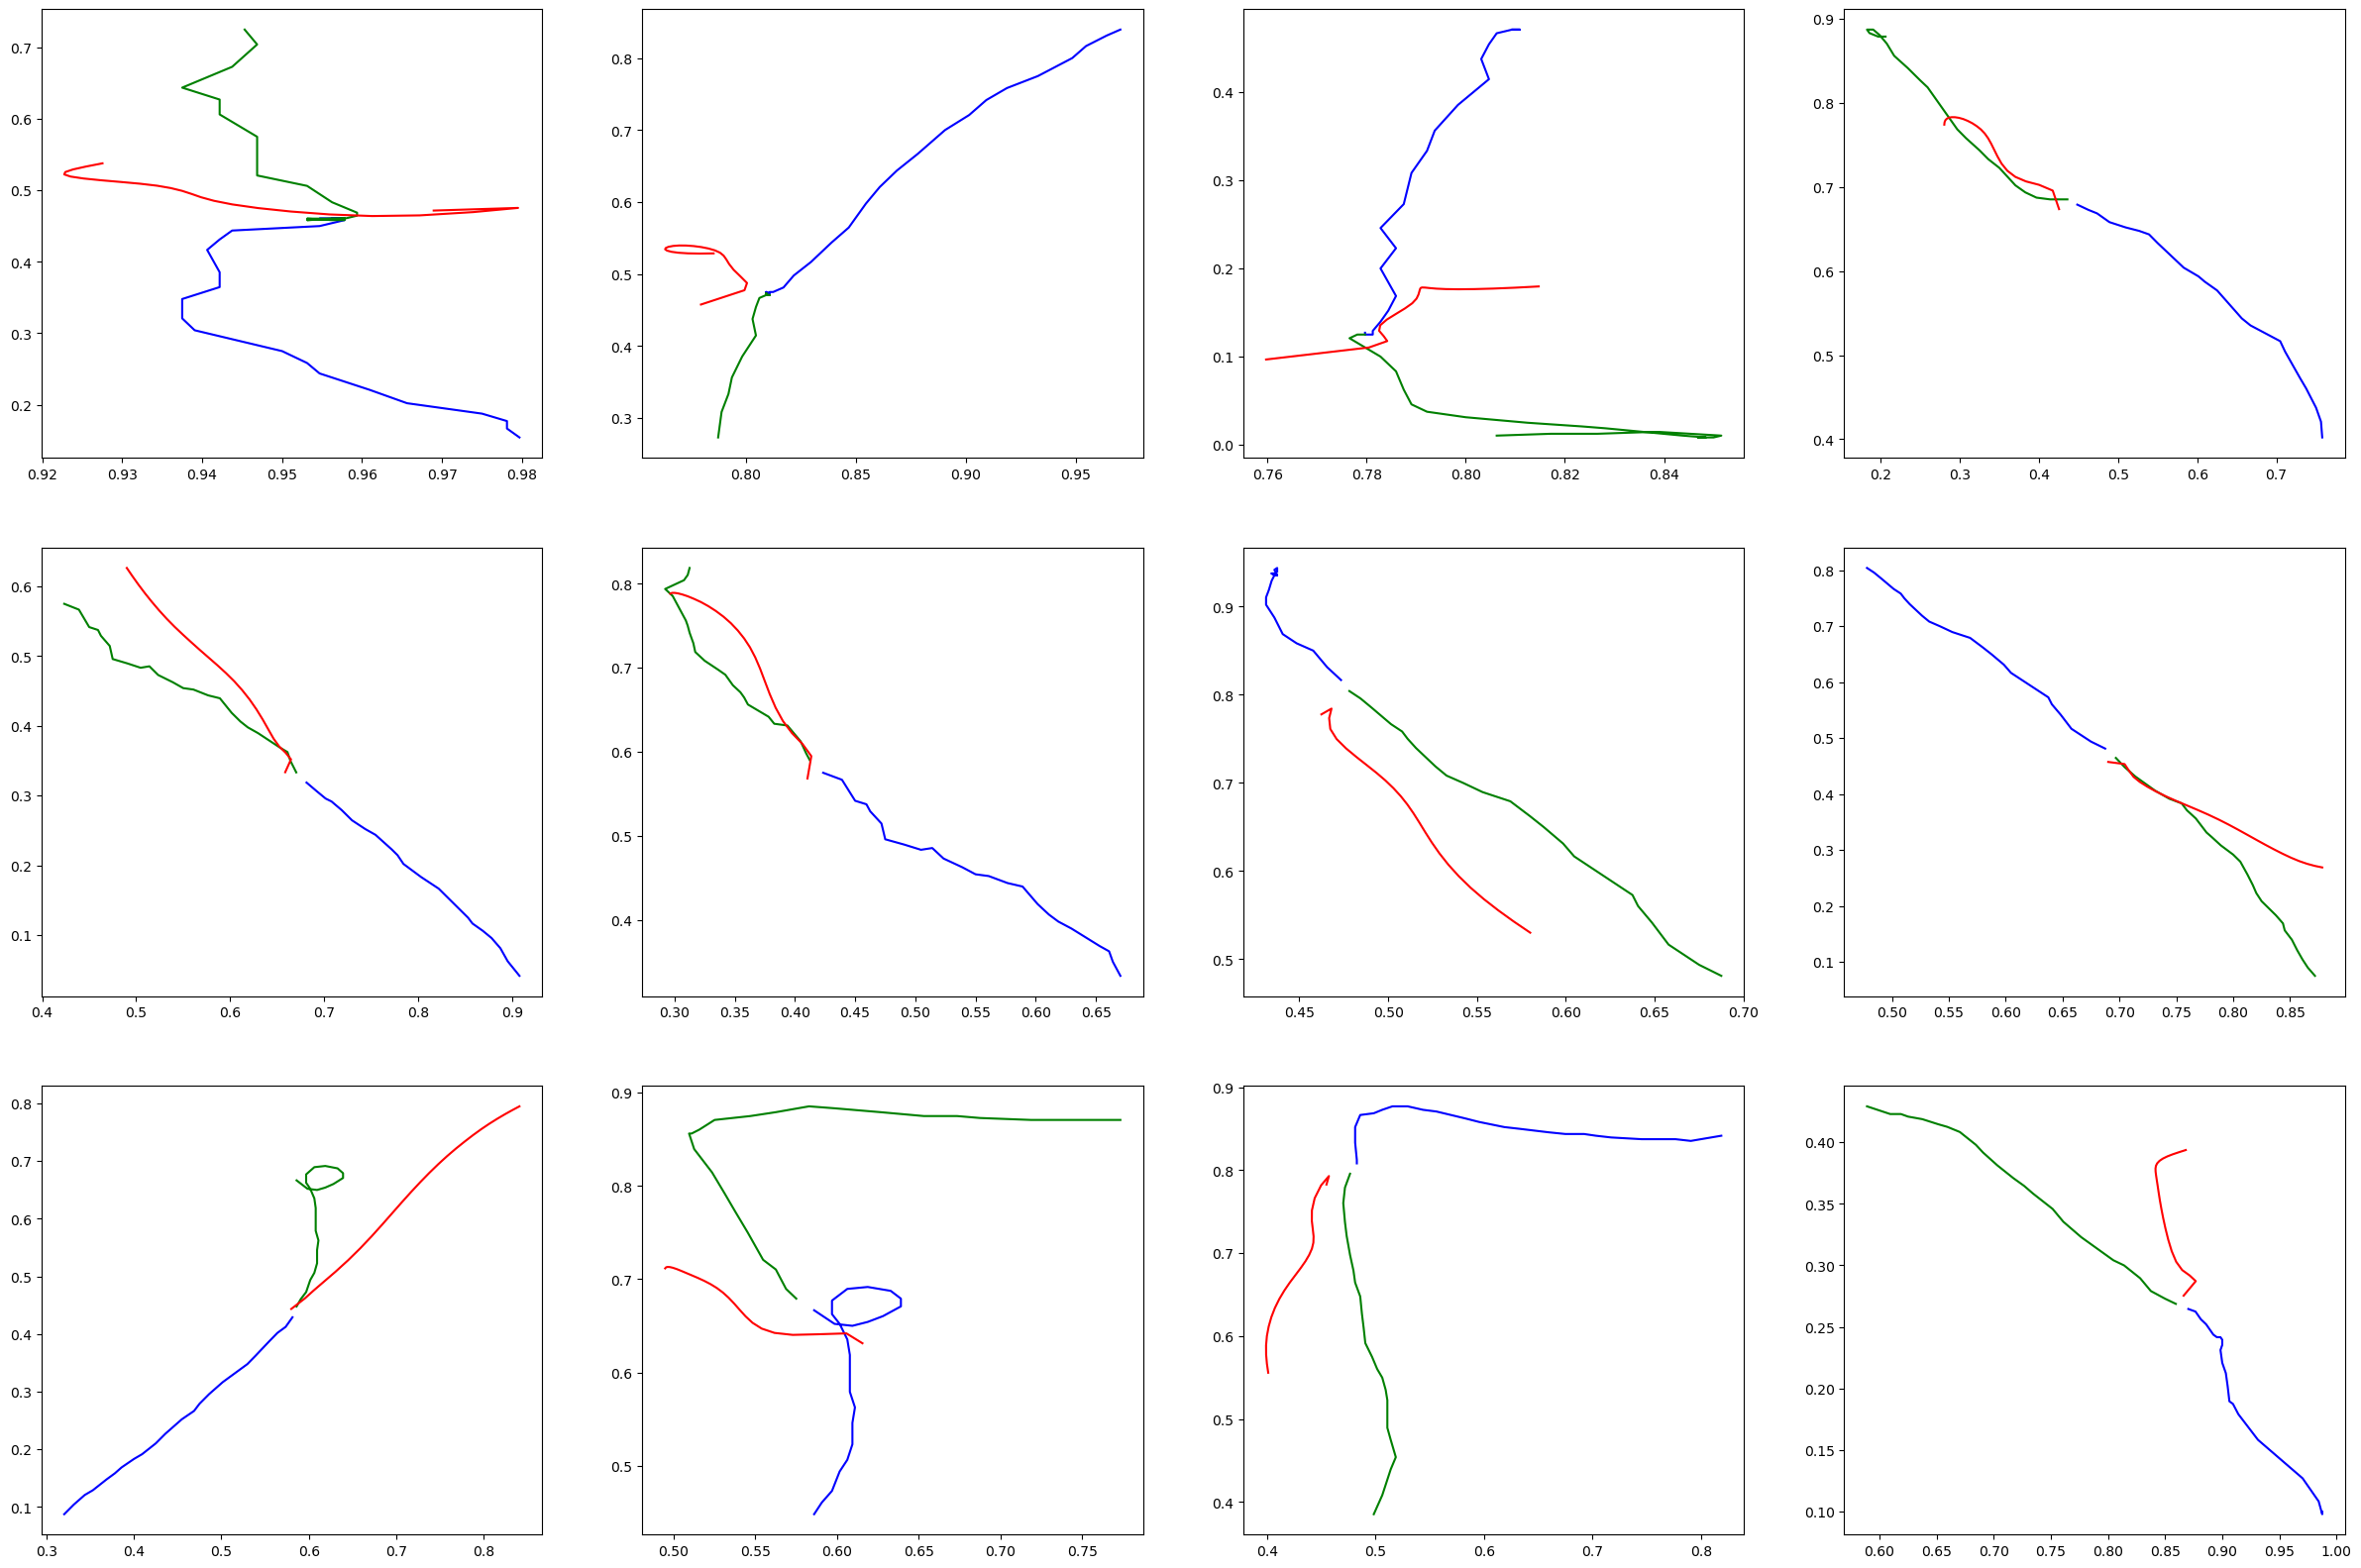

In [9]:
pred = model.predict(test_X)

fig = plt.figure(figsize=[30, 20])
for i in range(12):
    ax = fig.add_subplot(3, 4, i + 1)
    ax.plot(test_X[i*5,:,0], test_X[i*5,:,1], 'b')
    ax.plot(test_Y[i*5,:,0], test_Y[i*5,:,1], 'g')
    ax.plot(pred[i*5,:,0], pred[i*5,:,1], 'r')

Our results are weird. We get some that works ok, and a lot that look very odd. What's going on?

Part of the issue is that way that we make our prediction. We don't actually analyse the whole sequence, then predict the next sequence, rather we predict it as we go. The stacked LSTMs overcome this somewhat, but we can see that in a lot of cases we still get some pretty poor predictions.

## Approach 2: Bi-Directional LSTMs
We'll use a bi-directional LSTM now. This will parse the input both in the forwards and backwards directions, and thus do a better job of considering the entire input when generating the output. Out network is otherwise much the same as it was last time.

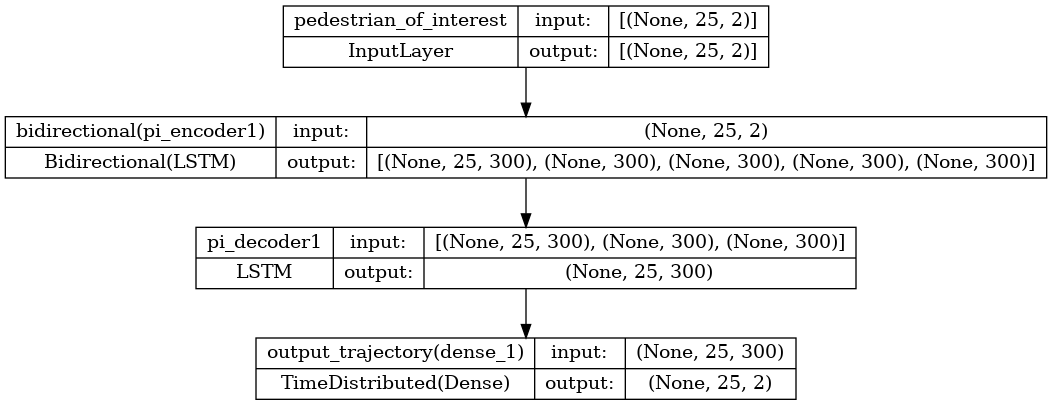

In [10]:
pi_input = Input(shape = (25, 2), name = 'pedestrian_of_interest')
encoder_outputs, e1_h, e1_c, _, _ = Bidirectional(LSTM(hidden_dim, return_sequences=True, return_state=True, 
                                                       unroll=False, name='pi_encoder1'), 
                                                  merge_mode='sum')(pi_input)
e1_states = [e1_h, e1_c]
decoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=False, 
                                unroll=False, name='pi_decoder1')(encoder_outputs, initial_state=e1_states)
output = TimeDistributed(Dense(2), name='output_trajectory')(decoder_lstm)

model = Model(pi_input, output)

model.compile('adam', 'mse', metrics=['accuracy'])
plot_model(model, show_shapes=True)

In [11]:
model.fit(train_X, train_Y,
          batch_size=128,
          epochs=20,
          validation_data=(test_X, test_Y))

Epoch 1/20
64/64 [==============================] - 6s 30ms/step - loss: 0.0528 - accuracy: 0.7554 - val_loss: 0.0270 - val_accuracy: 0.9026
Epoch 2/20
64/64 [==============================] - 1s 17ms/step - loss: 0.0267 - accuracy: 0.8670 - val_loss: 0.0363 - val_accuracy: 0.8303
Epoch 3/20
64/64 [==============================] - 1s 17ms/step - loss: 0.0247 - accuracy: 0.8778 - val_loss: 0.0300 - val_accuracy: 0.8661
Epoch 4/20
64/64 [==============================] - 1s 17ms/step - loss: 0.0170 - accuracy: 0.8934 - val_loss: 0.0151 - val_accuracy: 0.9326
Epoch 5/20
64/64 [==============================] - 1s 17ms/step - loss: 0.0133 - accuracy: 0.9031 - val_loss: 0.0097 - val_accuracy: 0.9338
Epoch 6/20
64/64 [==============================] - 1s 17ms/step - loss: 0.0122 - accuracy: 0.9108 - val_loss: 0.0140 - val_accuracy: 0.9129
Epoch 7/20
64/64 [==============================] - 1s 17ms/step - loss: 0.0105 - accuracy: 0.9192 - val_loss: 0.0090 - val_accuracy: 0.9462
Epoch 8/20
64

11/11 [==============================] - 1s 4ms/step


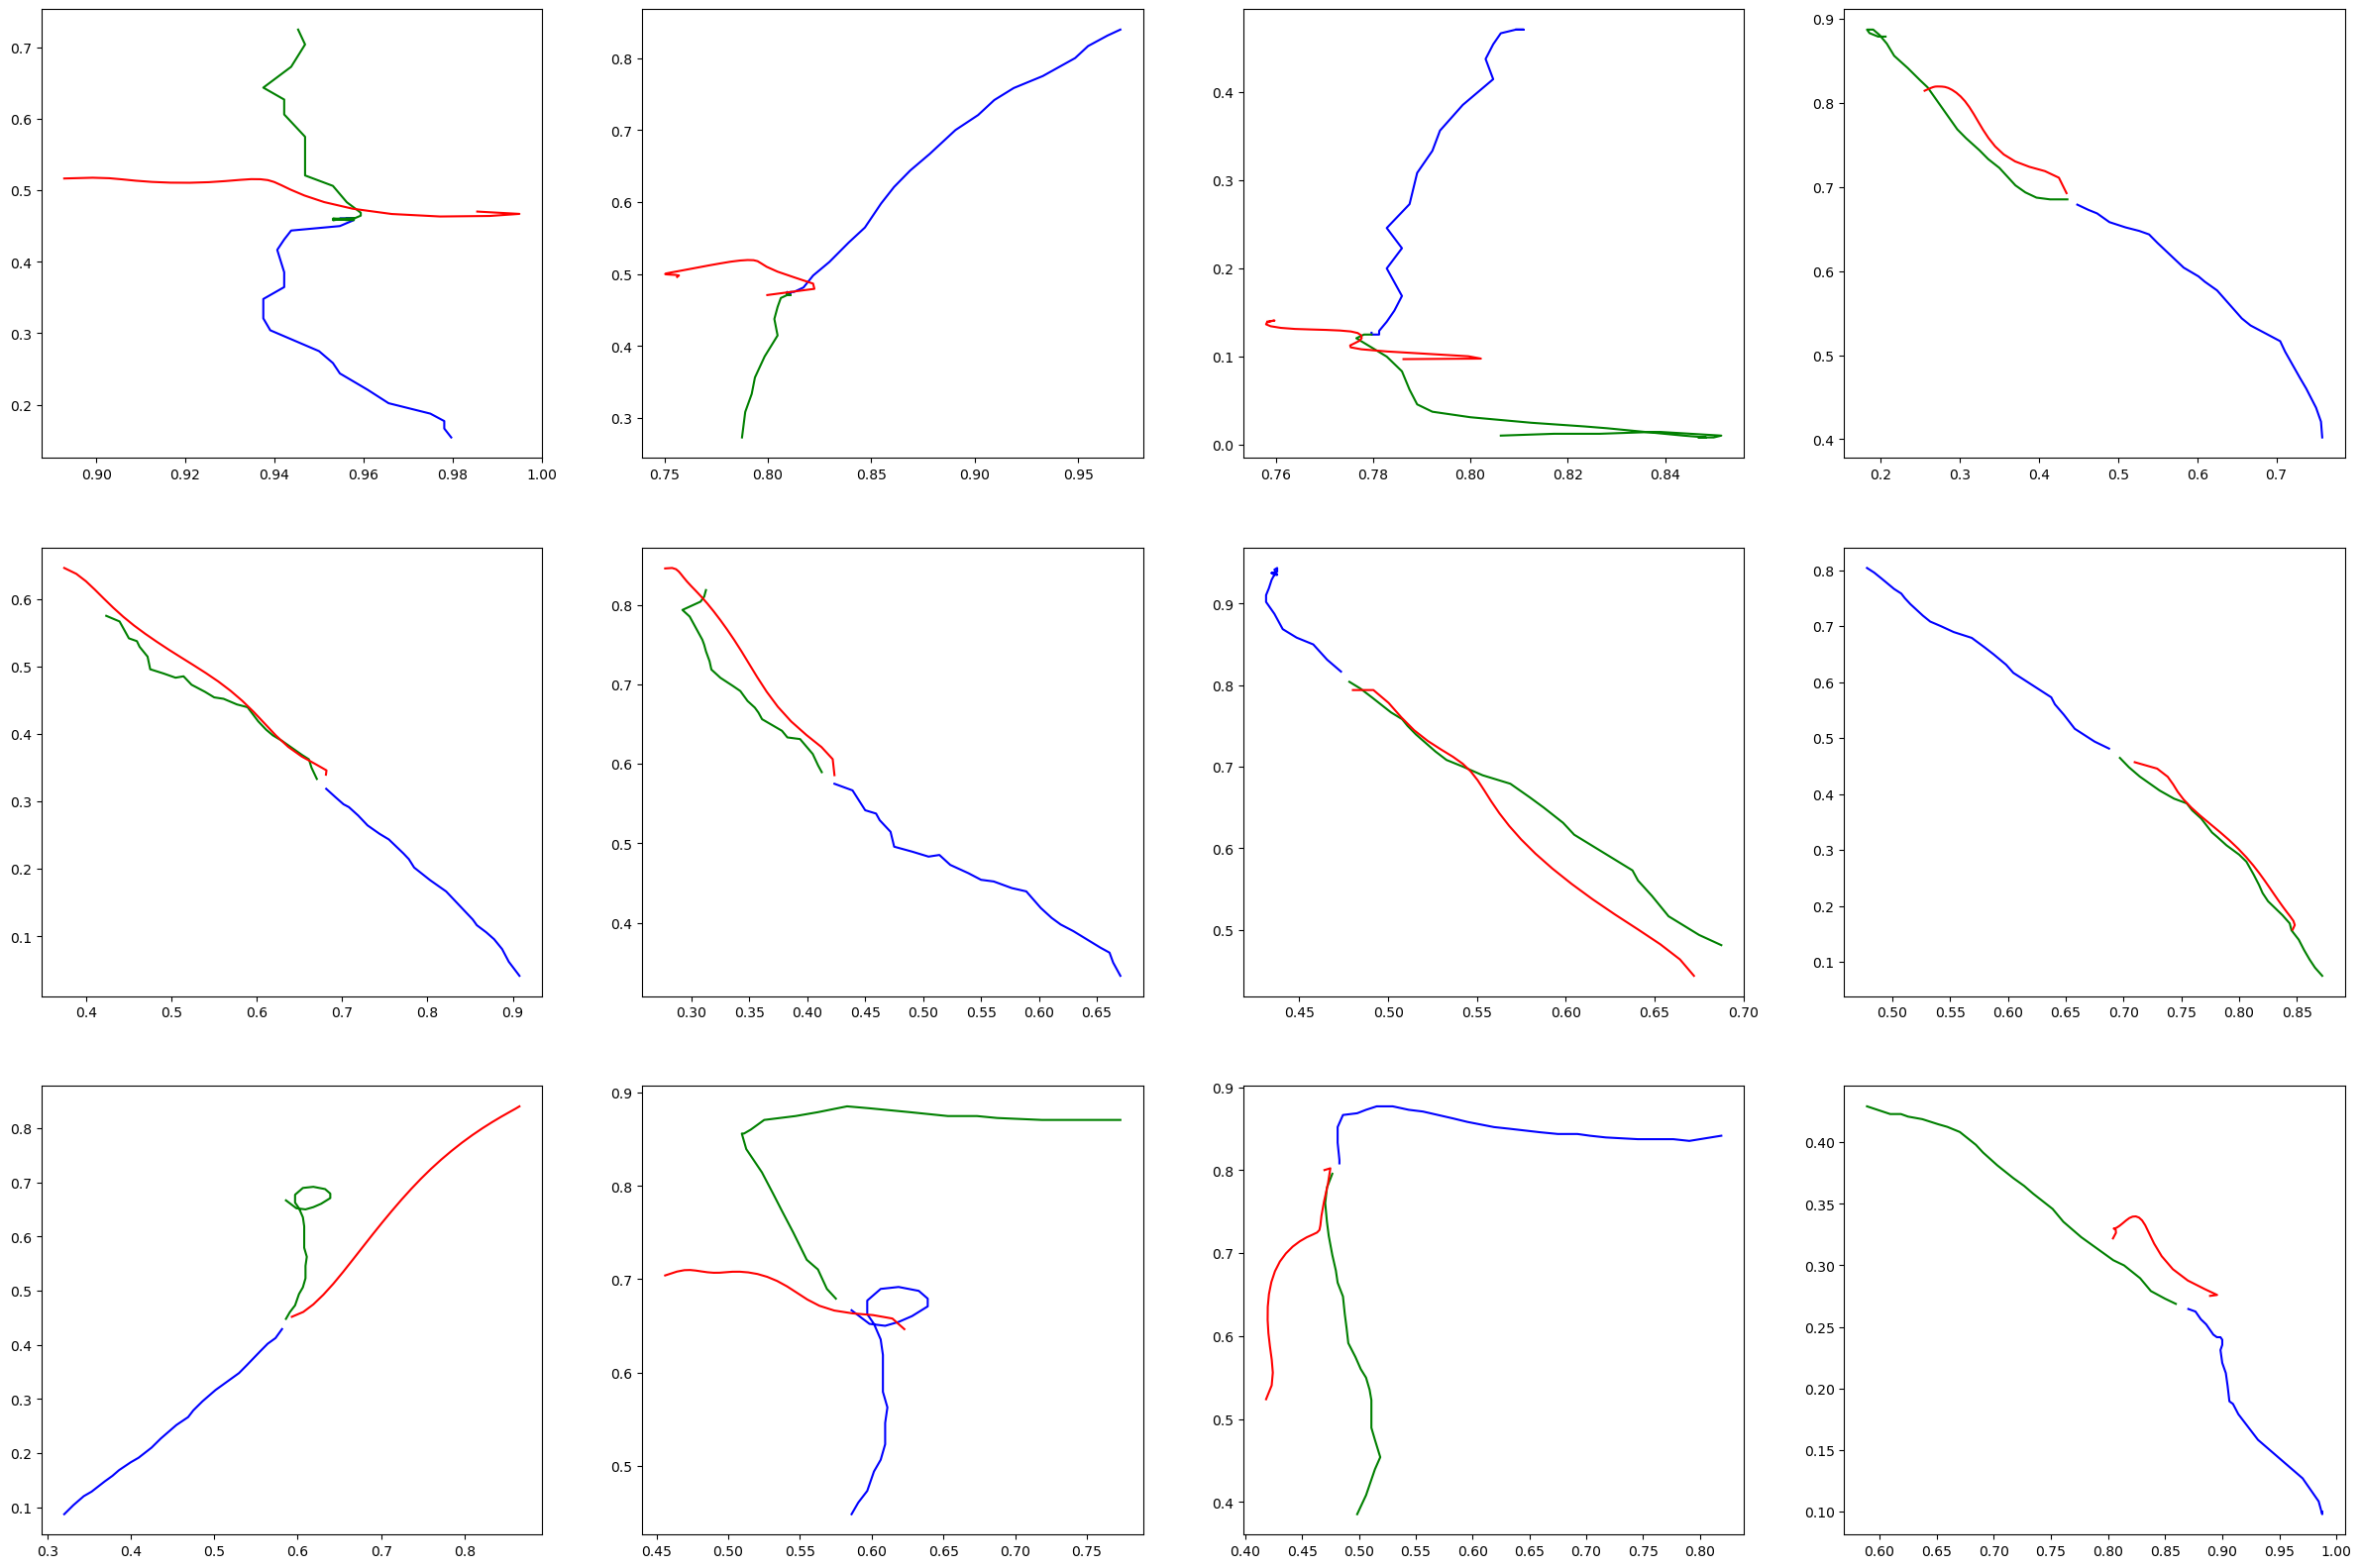

In [12]:
pred = model.predict(test_X)

fig = plt.figure(figsize=[30, 20])
for i in range(12):
    ax = fig.add_subplot(3, 4, i + 1)
    ax.plot(test_X[i*5,:,0], test_X[i*5,:,1], 'b')
    ax.plot(test_Y[i*5,:,0], test_Y[i*5,:,1], 'g')
    ax.plot(pred[i*5,:,0], pred[i*5,:,1], 'r')

Looking at the results, this looks much better, and much more like what we expect. We have a couple of weird ones in here, but these are typically the result of odd looking inputs, suggesting that there's more than just a poor performing model at play. By considering the entire sequence at once before making our prediction, we're able to do a much better job.

## Final Thoughts

We've looked at predicting sequences in this example. We can do this with LSTMs, and all we need to do is ask them to output a sequence. There some other things to consider though. By default, the LSTMs will not use the entire sequence to make the entire prediction, rather it will go through the sequence and predict one state/output at a time. We can somewhat overcome this using stacked LSTMs, but it's still not great. We get far better performance using a bi-directional LSTM which looks at the sequence in the forwards and backwards directions, and uses this to make the prediction.

There are some other things of note:
* Our loss function is limited here, in that we just do MSE over the whole trajectory. This actually makes it more important for the model to be correct at the end of the trajectory rather than the start, so we see disconnects between the previous and predicted paths.
* We haven't normalised our data as much as we could. We could for eaxmple, have centred every example, which would likely help learning
* We have not considered the embedding size we are using, or if it is optimal, rather we've just picked up. This could likely be improved.